In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf



%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [221]:
from fr_utils import *
from inception_blocks import *
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
FRmodel= faceRecoModel(input_shape=(3, 96, 96))

In [4]:
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [115]:
print(FRmodel.layers[101].name)

inception_2a


In [23]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [24]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [25]:
# Fill database here with image encodings
database = {}
database['Greg'] = img_to_encoding("images/greg_positive.jpg", FRmodel)
database['Maxim'] = img_to_encoding("images/maxim_positive.jpg", FRmodel)


In [26]:
def encode_image(image_path, model):
    return img_to_encoding(image_path, model)

In [27]:
def verify(image_path, identity, database, model, threshold=0.7):
    
    encoding = img_to_encoding(image_path, model)

    # Compute distance with identity's image 
    dist = np.linalg.norm(encoding-database[identity])
    
    if dist < threshold:
        print("It's " + str(identity) + ", identity confirmed. Distance is " + str(dist))
        identity_confirmed = True
    else:
        print("It's not " + str(identity) + ", identity denied. Distance is " + str(dist))
        identity_confirmed = False


    return dist, identity_confirmed

In [291]:
verify("images/maxim_anchor.jpg", "Greg", database, FRmodel)

It's not Greg, identity denied. Distance is 0.91445863


(0.91445863, False)

In [31]:
def who_is_it(image_path, database, model):

    encoding = encode_image(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        # L2 distance 
        dist = np.linalg.norm(encoding-db_enc)

        if dist < min_dist:
            min_dist = dist
            identity = name


    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("It's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

In [135]:
def layer_n_output_3D(n, image_path):
    get_nth_layer_output = K.function([FRmodel.layers[0].input],
                                     [FRmodel.layers[n].output])
    
    matrix1 = cv2.imread(image_path, 1)
    matrix = matrix1[...,::-1]
    matrix = np.around(np.transpose(matrix, (2, 0, 1))/255.0, decimals=12)
    matrix = np.array([matrix])
    
    pre_output = get_nth_layer_output([matrix])[0]
    
    output = pre_output[0]
    
    return output

In [144]:
def reshape_layer_output(layer_n_output):
    return np.moveaxis(layer_n_output, 0, -1)

In [146]:
def normalize_reshaped_layer_output(reshaped_layer_n_output):
    return np.linalg.norm(reshaped_layer_n_output, axis=-1)

In [284]:
def compare_two_faces(face_path_1, face_path_2, layer_num):
    face_1_output_3D = layer_n_output_3D(layer_num, face_path_1)
    face_2_output_3D = layer_n_output_3D(layer_num, face_path_2)
    
    reshapen_face_1 = reshape_layer_output(face_1_output_3D)
    reshapen_face_2 = reshape_layer_output(face_2_output_3D)
    
    #normalized_face_1 = normalize_reshaped_layer_output(reshapen_face_1)
    #normalized_face_2 = normalize_reshaped_layer_output(reshapen_face_2)
    
    #difference_matrix = normalized_face_1 - normalized_face_2
    difference_matrix = np.linalg.norm(reshapen_face_1 - reshapen_face_2, axis=-1)
    
    return abs(difference_matrix)

In [285]:
print((compare_two_faces("images/greg_anchor.jpg", "images/greg_positive.jpg", 101)))

[[1.7807927 3.3000193 3.0165348 3.0588722 2.5913117 1.8523998]
 [1.8212085 2.5752337 3.0649781 3.3698268 2.7493246 2.466854 ]
 [2.4606428 3.2083251 3.8953753 3.845895  2.993902  2.521517 ]
 [2.5460072 3.1193457 3.7706046 3.383678  3.0645778 2.5266557]
 [2.280741  2.30233   2.9325964 3.1266005 3.4736238 2.6822867]
 [2.1686175 2.3558335 2.5483634 2.925761  2.5132563 2.9581833]]


In [298]:
def overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix):
    
    positive_matrix = cv2.imread(positive_image_path)
    anchor_matrix = cv2.imread(anchor_image_path)
    
    num_sectors = len(difference_matrix[0])
    num_pixels_in_row = len(positive_matrix[0])
    
    ten_percentile = np.percentile(difference_matrix, 10)
    twentyfive_percentile = np.percentile(difference_matrix, 25)
    forty_percentile = np.percentile(difference_matrix, 40)
    sixty_percentile = np.percentile(difference_matrix, 60)
    seventyfive_percentile = np.percentile(difference_matrix, 75)
    ninety_percentile = np.percentile(difference_matrix, 90)
    
    print("num_sectors = " + str(num_sectors))
    print("pixels_in_row = " + str(num_pixels_in_row))
    
    
    for i in range(1, num_sectors):
        for j in range(1, num_sectors):
            
            #cur_section = anchor_matrix[np.ceiling((((i-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((i/num_sectors))*num_pixels_in_row))][np.ceiling((((j-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((j/num_sectors))*num_pixels_in_row))]
            cur_difference = difference_matrix[i][j]
            
            low_i = int(np.ceil(((i-2)/num_sectors) * num_pixels_in_row)) + 1
            high_i = int(np.ceil((i-1/num_sectors) * num_pixels_in_row))
            
            low_j = int(np.ceil(((j-2)/num_sectors) * num_pixels_in_row)) + 1
            high_j = int(np.ceil((j-1/num_sectors) * num_pixels_in_row))
            
            if cur_difference <= ten_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15        
            elif cur_difference <= twentyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("25")
            elif cur_difference <= forty_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("40")
            elif cur_difference <= sixty_percentile:
                a = None
            elif cur_difference <= seventyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("90")
            elif cur_difference <= ninety_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("90")
            else:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15
                #print("90")
                
    return anchor_matrix, positive_matrix

num_sectors = 6
pixels_in_row = 96


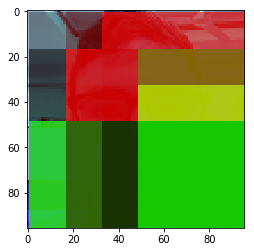

In [299]:
greg_anchor_mat, greg_pos_mat = overlay_difference_colors("images/maxim_positive.jpg", "images/greg_anchor.jpg", compare_two_faces("images/maxim_positive.jpg", "images/greg_anchor.jpg", 101))
img = Image.fromarray(greg_anchor_mat, 'RGB')
#img.show()
plt.imshow(img)

In [300]:
print(normalize_reshaped_layer_output(reshape_layer_output(layer_n_output_3D(101, "images/greg_anchor.jpg"))))

[[5.6895895 6.7565417 6.0477715 5.904791  7.1187644 5.916458 ]
 [5.0685406 5.7576504 6.857793  6.0740833 5.317924  6.4919324]
 [7.0377936 6.950414  8.029582  8.385611  6.590001  5.947912 ]
 [6.4266872 6.5968776 8.654822  8.511744  6.262946  5.7416034]
 [4.9825974 4.4894824 6.787461  7.0465736 5.7102365 5.195729 ]
 [5.2211223 5.2576966 5.7591896 6.4949393 6.0985475 6.2446017]]
